# Market generator Bühler - Kou Jump Model

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import datetime

# import base
import BuehlerVAE.src.market_generator as market_generator
from BuehlerVAE.src.utils import tosig

c:\Users\peter\OneDrive - TUM\Master TUM\Masterarbeit\MarketGenerators\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Signature order
order = 4

## Load monthly paths

In [3]:
ticker = "^GSPC"
method = "Kou_Jump_Diffusion"
params = {
    "S0": 1., 
    "mu": 0.12, 
    "sigma": 0.2, 
    "lambda_": 2.0, 
    "p": 0.3, 
    "eta1": 50., 
    "eta2": 25., 
    "n": 120
}
MG = market_generator.MarketGenerator(ticker, freq="M", sig_order=order, own_params=params, method=method)

Computing log-signatures: 100%|██████████| 120/120 [00:00<00:00, 7057.95it/s]


## Plot paths

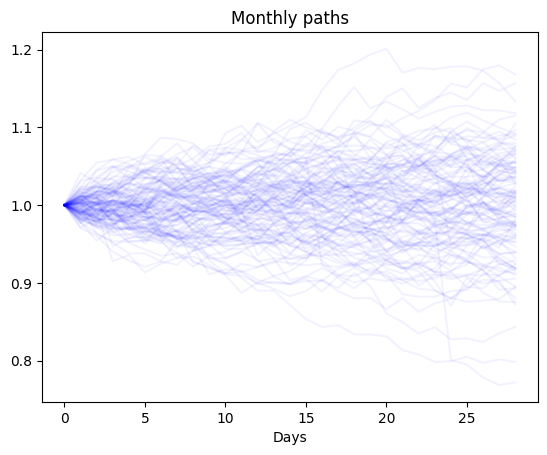

In [4]:
for path in MG.windows:
    returns = path[::2, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [5]:
MG.train(n_epochs=10000)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Training: 100%|██████████| 10000/10000 [00:12<00:00, 818.09it/s]


## Generate

In [6]:
generated = np.array([MG.generate(cond) for cond in MG.conditions])
#generated = MG.generate(MG.conditions[100], n_samples=len(MG.logsigs))
#generated = MG.generate(MG.conditions[150][2] * 0.5, n_samples=len(MG.logsigs))

generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.orig_logsig)])

100%|██████████| 120/120 [00:01<00:00, 63.38it/s]


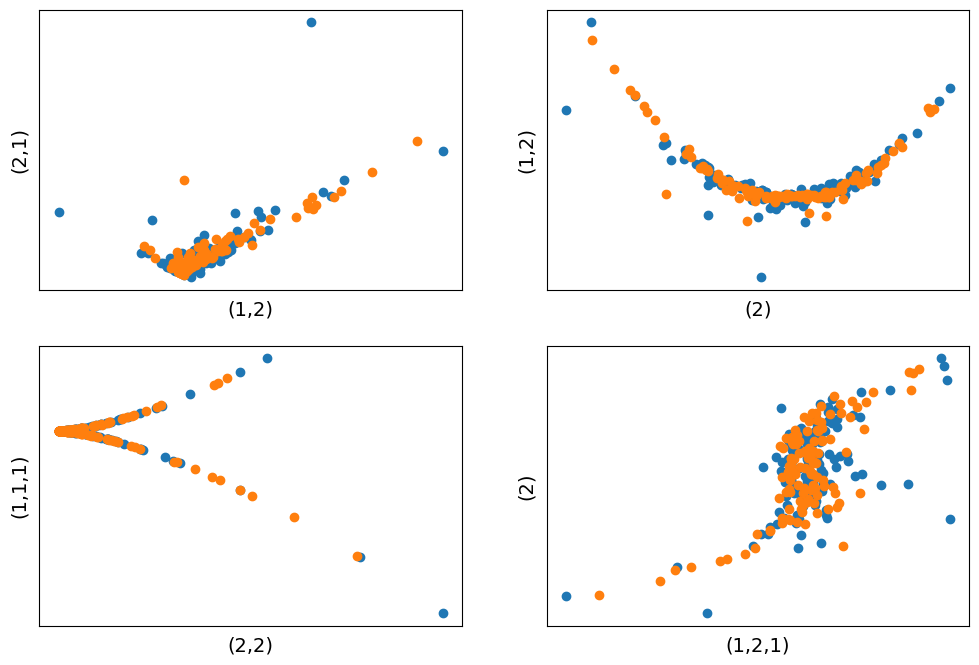

In [7]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(real_sigs[:, projection[0]], real_sigs[:, projection[1]],
                label="Real data")
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated")
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

In [16]:
import BuehlerVAE.src.process_discriminator as process_discriminator

normalised_generated = np.array([MG.generate(cond, normalised=True) for cond in MG.conditions])
sigs1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(normalised_generated)])
MG._load_own_data(params, method)
sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.logsigs)])

res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.9999) # true for 0.99999 or more

print("Are the generated and real distributions DIFFERENT? {}".format(res))

Computing signatures of population 2: 100%|██████████| 119/119 [00:00<00:00, 2105.00it/s]

Are the generated and real distributions DIFFERENT? True


## Invert log-signature

In [17]:
import BuehlerVAE.src.logsig_inversion as logsig_inversion
from esig.tosig import stream2logsig
from BuehlerVAE.src.utils.leadlag import leadlag

logsig = MG.generate(MG.conditions[0])

In [18]:
pip = 0.001
n_pips = 5 * 10
n_points = 21

n_iterations = 100
n_organisms = 100

recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.009765977602430878: 100%|██████████| 100/100 [00:04<00:00, 21.64it/s]


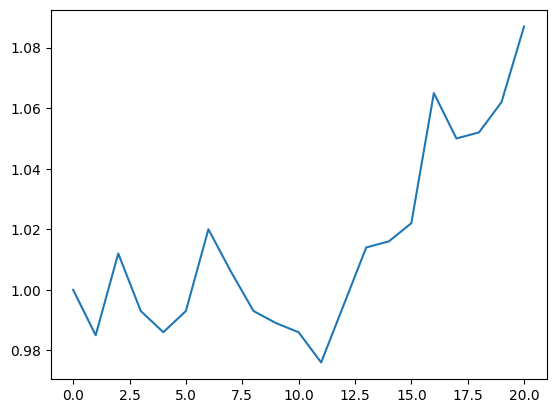

Target log-signature: [0.08645876497030258, 0.08705756068229675, -0.003136616200208664, 6.0811213188571855e-05, 5.2772873459616676e-05, -1.0556583447396406e-06, -1.819627527765988e-06, -9.022096492117271e-07]
Recovered log-signature: [0.08700000000000001, 0.08700000000000001, -0.0030984999999999997, 7.304825e-05, 5.1413749999999995e-05, -1.074952166666667e-06, -1.7336411250000006e-06, -8.861041666666672e-07]


In [19]:
plt.plot(1 + recovered_path)
plt.show()
print(f"Target log-signature: {logsig.tolist()}")
print(f"Recovered log-signature: {stream2logsig(leadlag(recovered_path), order).tolist()}")

In [20]:
recovered_paths = []
for condition in MG.conditions:
    logsig = MG.generate(condition)
    recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                                  pip, n_pips)
    
    recovered_paths.append(recovered_path)

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.017376745262978183: 100%|██████████| 100/100 [00:05<00:00, 18.13it/s]


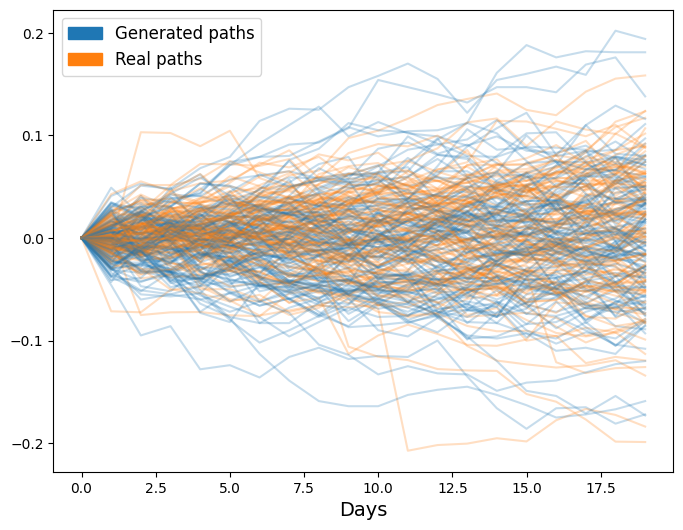

In [21]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8, 6))
for path1, path2 in zip(recovered_paths, MG.windows):
    returns = path2[::2, 1][:20] - path2[0, 1]
    plt.plot(returns, "C1", alpha=0.25)

    plt.plot(path1[:20], "C0", alpha=0.25)
    
blue_patch = mpatches.Patch(color='C0', label='Generated paths')
red_patch = mpatches.Patch(color='C1', label='Real paths')
plt.legend(handles=[blue_patch, red_patch], fontsize=12)    
plt.xlabel("Days", fontsize=14) 
plt.show()

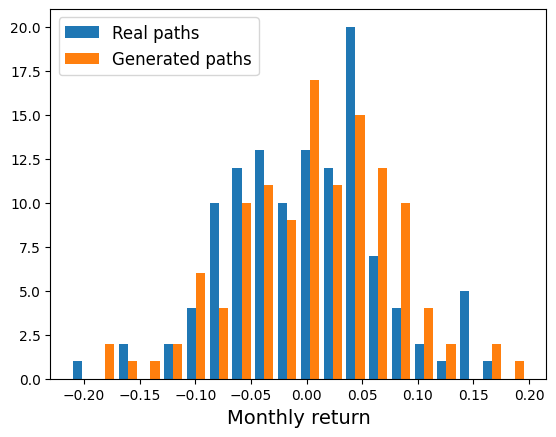

In [22]:
# This graph is somewhat week as the return over the whole month can be #
# extracted from the signature directly from the first order terms (also for log-signature?)
returns1 = [path[-1] - path[0] for path in recovered_paths]
returns2 = [path[-1, 1] - path[0, 0] for path in MG.windows]

_ = plt.hist([returns1, returns2], bins=20, label=["Generated paths", "Real paths"])
plt.xlabel("Monthly return", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [23]:
def concatenate(condition, periods):
    joined_path = None

    for _ in range(periods):
        generated = MG.generate(condition)
        path, loss = logsig_inversion.train(generated, order, n_iterations, n_organisms, n_points,
                                            pip, n_pips)

        condition = tosig.stream2logsig(market_generator.leadlag(recovered_path), order)
        condition = MG.scaler.transform([condition])[0]

        if joined_path is None:
            joined_path = path
        else:
            joined_path = np.r_[joined_path, np.add(path[1:], joined_path[-1])]
            
    return joined_path

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.022721772801851857: 100%|██████████| 100/100 [00:05<00:00, 18.75it/s]


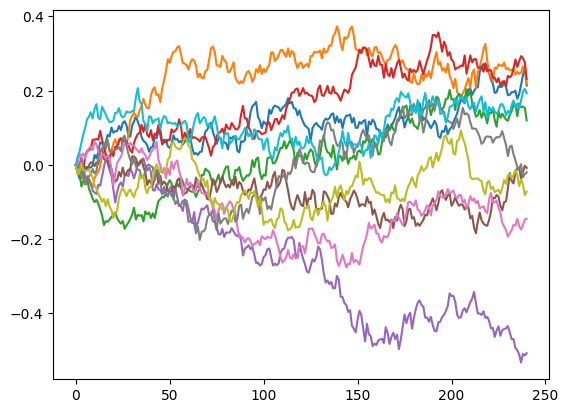

In [25]:
idx = 100

condition = MG.conditions[idx]

paths = [concatenate(condition, 12) for _ in range(10)]

plt.plot(np.transpose(paths))
plt.show()

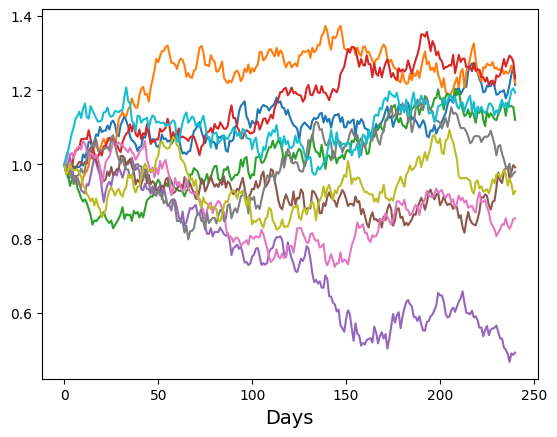

In [26]:
plt.plot(MG.windows[idx + 1][0, 0] + np.transpose(paths))
plt.xlabel("Days", fontsize=14) 
plt.show()